In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf
import numpy as np

In [2]:
def extract_persian_year_month(idx_str: str) -> str:
    """
    Extract YYYY/MM from strings like 'ماه 3 منتهی به 1400/03'.
    """
    import re
    try:
        match = re.search(r'(\d{4}/\d{1,2})', str(idx_str))
        if match:
            year, month = match.group(1).split("/")
            return f"{year}/{month.zfill(2)}"
    except Exception:
        pass
    return "Unknown"

def format_acf_results(acf_output, nlags):
    """
    Formats the output of the statsmodels acf function into a pandas DataFrame.

    Args:
        acf_output (tuple): The tuple returned by the statsmodels.tsa.stattools.acf function.
                            Expected format: (acf_values, confint, qstat, pvalues)
        nlags (int): The number of lags used to calculate the ACF.

    Returns:
        pandas.DataFrame: A DataFrame with the formatted ACF results, indexed by lag.
    """
    # Unpack the tuple from the acf function
    acf_values, confint = acf_output[0:2]

    # Calculate the lower and upper bounds of the confidence interval
    # The confint array is of shape (nlags+1, 2), where the first column
    # is the lower bound and the second is the upper bound.
    # We subtract the acf_values to get the interval margin.
    conf_lower = confint[:, 0] - acf_values
    conf_upper = confint[:, 1] - acf_values

    # Create a dictionary to hold the data
    # We start from lag 1, so we slice the arrays [1:]
    data = {
        'ACF': acf_values[1:],
        'Conf. Int. Lower': conf_lower[1:],
        'Conf. Int. Upper': conf_upper[1:]
    }

    # Create the DataFrame
    # The index will be the lags from 1 to nlags
    df = pd.DataFrame(data, index=np.arange(1, nlags + 1))
    
    # Set display options for pandas to format floats nicely
    pd.set_option('display.float_format', lambda x: f'{x:.4f}')

    return df


In [3]:
df = pd.read_excel("تولید و فروش ماهانه کاوه.xlsx").iloc[1,3:]
df.index = df.index.map(extract_persian_year_month)

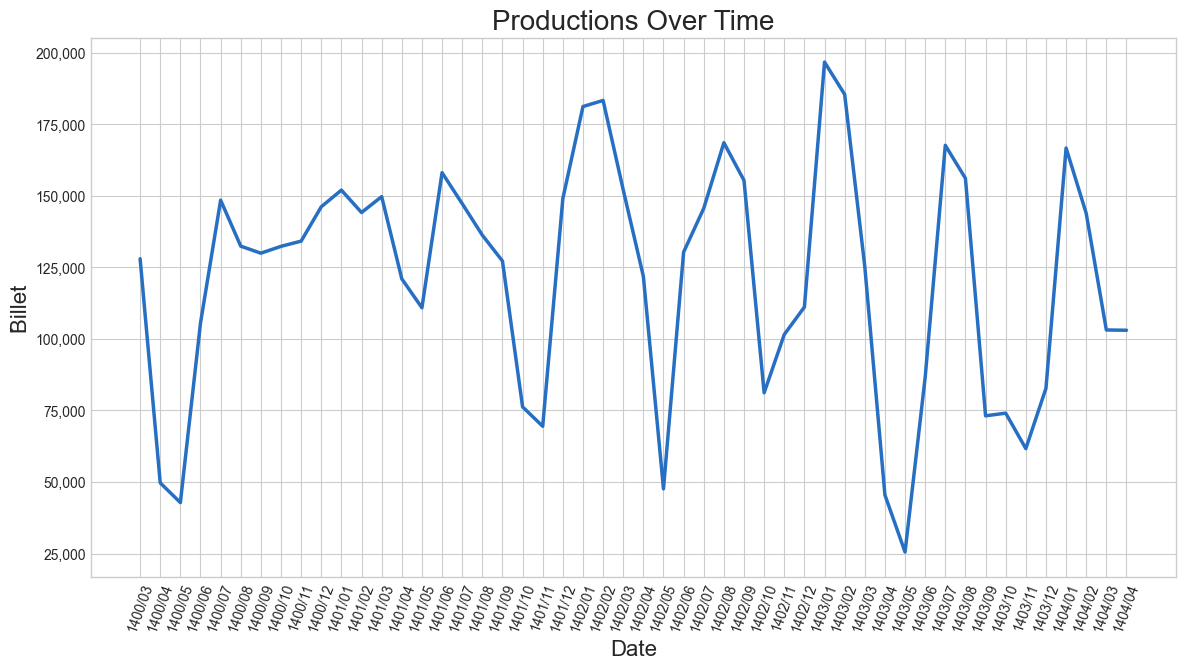

In [4]:
plt.style.use('seaborn-v0_8-whitegrid')

main_color = "#276fc2"
plt.figure(figsize=(14 ,7))
plt.plot(df, color=main_color,linewidth=2.5)

plt.title('Productions Over Time', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('ّBillet', fontsize=16)
plt.xticks(rotation=70)

# --- Add these two lines to format the y-axis ---
from matplotlib.ticker import FuncFormatter
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

#### Show the plot
plt.show()

In [5]:
acf_values = acf(df, nlags=12,alpha=0.05)
format_acf_results(acf_values, nlags=12)

,ACF,Conf. Int. Lower,Conf. Int. Upper
1,0.4600,-0.2772,0.2772
2,-0.2312,-0.3307,0.3307
3,-0.5166,-0.3429,0.3429
4,-0.2664,-0.3982,0.3982
5,0.2846,-0.4117,0.4117
6,0.5534,-0.4265,0.4265
7,0.2464,-0.4785,0.4785
8,-0.3104,-0.4882,0.4882
9,-0.4665,-0.5031,0.5031
10,-0.2255,-0.5353,0.5353


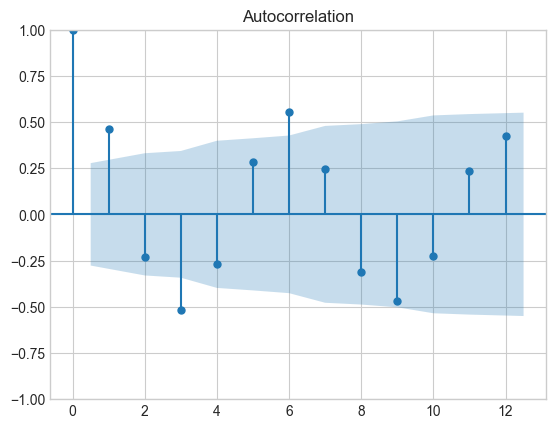

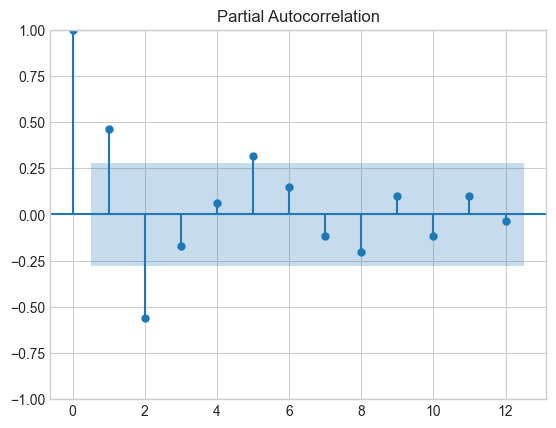

In [6]:
plot_acf(df,lags=12,alpha=0.05)
plot_pacf(df, lags=12, alpha=0.05, method='ywm')
"""
"ywm" (default) – Yule-Walker without adjustment.

Other methods include "yw", "ols", "ld" (Levinson-Durbin), etc.
"""
plt.show()

In [7]:
df = df.astype(float)
import warnings
import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm

warnings.filterwarnings("ignore")

# Assume df is your production series, already numeric
# df = df.astype(float)

# SARIMA parameter ranges
p = d = q = range(0, 6)
P = D = Q = range(0, 2)
s = 12

best_aic = float("inf")
best_order = None
best_seasonal_order = None
best_model = None

# Generate all combinations
all_orders = list(itertools.product(p, d, q))
all_seasonal_orders = list(itertools.product(P, D, Q))

# Total iterations for tqdm
total_iterations = len(all_orders) * len(all_seasonal_orders)

# Outer loop with tqdm for progress bar
for order, seasonal_order in tqdm(itertools.product(all_orders, all_seasonal_orders), total=total_iterations):
    try:
        model = SARIMAX(df,
                        order=order,
                        seasonal_order=(seasonal_order[0], seasonal_order[1], seasonal_order[2], s),
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
            best_seasonal_order = seasonal_order
            best_model = results
    except:
        continue

print("Best SARIMA model:")
print(f"Order: {best_order}, Seasonal order: {best_seasonal_order}, AIC: {best_aic}")

100%|██████████| 1728/1728 [07:13<00:00,  3.98it/s]

Best SARIMA model:
Order: (2, 0, 1), Seasonal order: (0, 1, 1), AIC: 10.0
